In [1]:
import sys
old_stdout = sys.stdout
from two_stream import Two_stream

import cv2
import numpy as np
import configparser


In [2]:
f = open('/dev/null', 'w')
#sys.stdout = f

two_stream = Two_stream('./files/config.config')

config = configparser.ConfigParser()
config.read('./files/config.config')
size = (ch,h,w) = (config['OpticalFlow']['channel'],
                   int(config['DataConfig']['image_height']),
                   int(config['DataConfig']['image_width'])) #(20,256,256)

## read images
img1 = cv2.imread("LK_optical_flow/files/img_00000.jpg")
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1 = cv2.resize(img1,(w,h)).astype(np.uint8)

img2 = cv2.imread("LK_optical_flow/files/img_00001.jpg")
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2,(w,h)).astype(np.uint8)

#two_stream(img1, img2)

sys.stdout = old_stdout
print("\t[Info] finish one iter test")

	[Info] buff depth 65536
	[Info] buff depth 131072
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 65536
shape of wgt:  (32, 16, 3, 3)
shape of wgt:  (64, 32, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memo

In [3]:
two_stream.cnn_acc0.img_channel, two_stream.cnn_acc0.input_buff.shape, two_stream.cnn_acc0.buffer_depth

(16, (65536, 16), 65536)

In [4]:
del two_stream

# Demo Video smooth version

In [5]:
from LK_optical_flow.utils import showarray
from two_stream import Two_stream

import os, sys, cv2, time
old_stdout = sys.stdout

import configparser
import numpy as np

from contextlib import contextmanager

@contextmanager
def silence_stdout():
    old_target = sys.stdout
    try:
        with open(os.devnull, "w") as new_target:
            sys.stdout = new_target
            yield new_target
    finally:
        sys.stdout = old_target
        

In [6]:
## configs
config = configparser.ConfigParser()
config.read('./files/config.config')

size = (ch,h,w) = (config['OpticalFlow']['channel'],
                   int(config['DataConfig']['image_height']),int(config['DataConfig']['image_width'])) #(20,256,256)

fps_list = []
start,end,sec = 0,0,1e-4

In [7]:
import ctypes
import numpy as np
import multiprocessing as mp

from multiprocessing import Process

def action_recogn_job(curr_frame, prev_frame, output):
    global two_stream
    
    with silence_stdout():
        output[:] = two_stream(curr_frame, prev_frame)

output = mp.Array(ctypes.c_float, 101)
ps_two_stream = None #Process(target=self.spatial_job, args=(input_frame, 0))


In [8]:
two_stream = Two_stream('./files/config.config')

	[Info] buff depth 65536
	[Info] buff depth 131072
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 131072
	[Info] buff depth 65536
shape of wgt:  (32, 16, 3, 3)
shape of wgt:  (64, 32, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
shape of wgt:  (64, 64, 3, 3)
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memory allocation...
memory allocation...: done
	[Info] buff depth 131072
memo

In [ ]:

def demo(video_path='LK_optical_flow/files/Big.Buck.Bunny.mp4'):
    global sec, output, ps_two_stream, h, w
    
    # put demo video
    cap = cv2.VideoCapture(video_path)

    prev_frame = np.zeros((h,w,3)).astype(np.uint8)
    prev_frame_gray = np.zeros((h,w)).astype(np.uint8)
    while(True):
        start = time.time()

        ret,frame = cap.read()
        if ret:
            curr_frame = cv2.resize(frame, (h, w))
            curr_frame = cv2.cvtColor(curr_frame, cv2.COLOR_BGR2RGB)
            curr_frame_gray = cv2.cvtColor(curr_frame, cv2.COLOR_RGB2GRAY)

            # luccas kannade , fbank
            vx,vy = two_stream.lucas_kanade_acc.compute(prev_frame_gray, curr_frame_gray)
            two_stream.feature_bank.push(vx,vy)

            if ps_two_stream==None or not ps_two_stream.is_alive():
                ps_two_stream = Process(target=action_recogn_job, args=(curr_frame, prev_frame, output))
                ps_two_stream.start()

            ## class 
            #pred_action = (np.argmax(output[:]))+1
            k = 2
            pred_action = np.argpartition(np.array(output), -k)[-k:]+1 #top-k

            prev_frame = curr_frame
            prev_frame_gray = curr_frame_gray

            ####################
            ##### just show ####
            vx = np.expand_dims(vx, axis=2)
            vy = np.expand_dims(vy, axis=2)
            #vv = np.sqrt((vx**2+vy**2))
            vv = np.zeros((h,w,1))
            v = np.concatenate((vv,vx,vy),axis=2).astype(np.uint8)
            showarray(np.concatenate((curr_frame,v),axis=1), 1/sec, topk=pred_action)
            ####################
            #showarray(curr_frame, 1/sec, show_meta=False)
        else:
            break

        end = time.time()
        sec = end-start
        fps_list.append(1/sec)
        #print(sec)

    print(f"avg fps:{sum(fps_list)/len(fps_list)}")


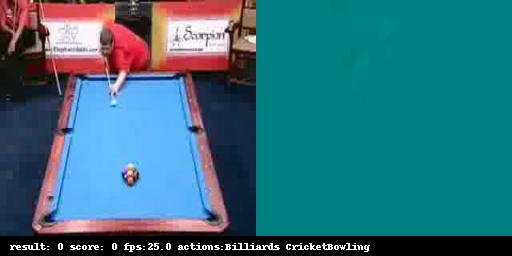

In [ ]:
video_candidate = ['LK_optical_flow/files/v_Billiards_g08_c01.avi', #top-1 billards V
                   'LK_optical_flow/files/v_Billiards_g08_c03.avi', #top-1 billards V
                   'LK_optical_flow/files/v_BasketballDunk_g01_c01.avi', #top-2 basketballdunk V
                   'LK_optical_flow/files/v_BasketballDunk_g01_c02.avi', #top-2 basketballdunk V
                   'LK_optical_flow/files/v_BasketballDunk_g01_c03.avi', #top-2 basketballdunk V 
                   'LK_optical_flow/files/v_Punch_g05_c02.avi', #top-3 punch V
                   'LK_optical_flow/files/v_Punch_g05_c03.avi', #top-3 punch V
                   'LK_optical_flow/files/v_Punch_g05_c04.avi', #top-3 punch V
                   'LK_optical_flow/files/v_IceDancing_g13_c02.avi', # icedancing V
                   'LK_optical_flow/files/v_SumoWrestling_g13_c02.avi', # sumowrestling
                   'LK_optical_flow/files/v_SumoWrestling_g13_c03.avi', # sumowrestling
                   'LK_optical_flow/files/v_SumoWrestling_g13_c04.avi', # sumowrestling
                    ]

for vd in video_candidate*10:
    demo(vd)
    

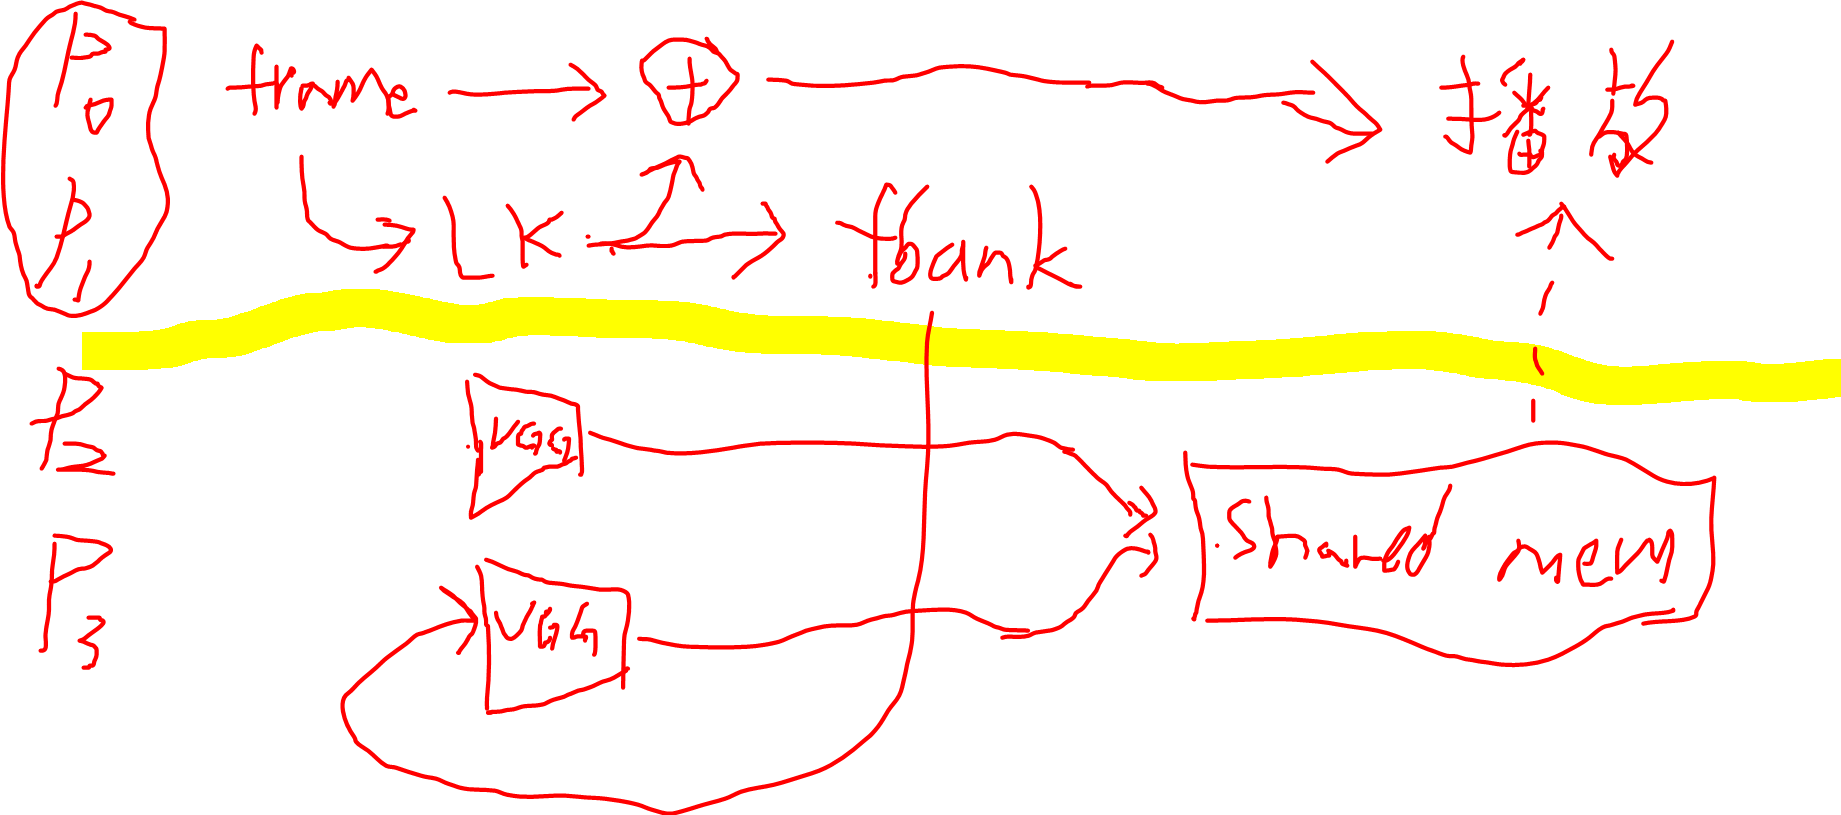